In [1]:
import time
import torch
from torch import nn, cuda, device, optim
import torchvision as tv
from torch.autograd import Variable
from torchsummary import summary

from matplotlib import pyplot as plt

print(cuda.is_available())
device = device('cuda:0')
print(device)

True
cuda:0


In [2]:
class Encoder(nn.Module):
    def __init__(self, nc, nf, nz):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, nf, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf, nf*2, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf*2, nf*4, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nf*4, nf*8, 5, 2, 2, bias=False),
            nn.BatchNorm2d(nf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(in_features=2*4*4*nf*4, out_features=1024),
            nn.BatchNorm1d(num_features=1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.mu = nn.Linear(in_features=1024, out_features=nz)
        #self.var = nn.Linear(in_features=1024, out_features=nz)

    def forward(self, input):
        y =  self.net(input)
        return self.mu(y)#, self.var(y)

In [3]:
enc = Encoder(nc=3, nf=32, nz=400).to(device)
summary(enc, (3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024]                --
|    └─Conv2d: 2-1                       [-1, 32, 32, 32]          2,400
|    └─BatchNorm2d: 2-2                  [-1, 32, 32, 32]          64
|    └─LeakyReLU: 2-3                    [-1, 32, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 64, 16, 16]          51,200
|    └─BatchNorm2d: 2-5                  [-1, 64, 16, 16]          128
|    └─LeakyReLU: 2-6                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-7                       [-1, 128, 8, 8]           204,800
|    └─BatchNorm2d: 2-8                  [-1, 128, 8, 8]           256
|    └─LeakyReLU: 2-9                    [-1, 128, 8, 8]           --
|    └─Conv2d: 2-10                      [-1, 256, 4, 4]           819,200
|    └─BatchNorm2d: 2-11                 [-1, 256, 4, 4]           512
|    └─LeakyReLU: 2-12                   [-1, 256, 4, 4]         

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024]                --
|    └─Conv2d: 2-1                       [-1, 32, 32, 32]          2,400
|    └─BatchNorm2d: 2-2                  [-1, 32, 32, 32]          64
|    └─LeakyReLU: 2-3                    [-1, 32, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 64, 16, 16]          51,200
|    └─BatchNorm2d: 2-5                  [-1, 64, 16, 16]          128
|    └─LeakyReLU: 2-6                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-7                       [-1, 128, 8, 8]           204,800
|    └─BatchNorm2d: 2-8                  [-1, 128, 8, 8]           256
|    └─LeakyReLU: 2-9                    [-1, 128, 8, 8]           --
|    └─Conv2d: 2-10                      [-1, 256, 4, 4]           819,200
|    └─BatchNorm2d: 2-11                 [-1, 256, 4, 4]           512
|    └─LeakyReLU: 2-12                   [-1, 256, 4, 4]         

In [4]:
class Unflatten(nn.Module):
    def __init__(self, shape):
        super(Unflatten, self).__init__()
        self.shape = shape
        
    def forward(self, input):
        return input.view(len(input), self.shape[0], self.shape[1], self.shape[2])
    
class Decoder(nn.Module):
    def __init__(self, nc, nz, nf):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=nz, out_features=2*4*4*nf*4),
            nn.BatchNorm1d(num_features=2*4*4*nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            Unflatten((256, 4, 4)),
            
            # add output_padding=1 to ConvTranspose2d to reconstruct original size
            nn.ConvTranspose2d(nf*8, nf*4, 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # add output_padding=1 to ConvTranspose2d to reconstruct original size
            nn.ConvTranspose2d(nf*4, nf*2, 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(nf*2, nf, 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(nf, int(nf/2), 5, 2, 2, 1, bias=False),
            nn.BatchNorm2d(int(nf/2)),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(int(nf/2), nc, 5, 1, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.net(input)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, nc, nz, nf):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, 1000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.net(input)

In [6]:
dec = Decoder(nc=3, nz=400, nf=32).to(device)
dis = Discriminator(nc=3, nz=400, nf=32).to(device)

summary(dis, (1, 400))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1]                --
|    └─Linear: 2-1                       [-1, 1, 1000]             401,000
|    └─LeakyReLU: 2-2                    [-1, 1, 1000]             --
|    └─Linear: 2-3                       [-1, 1, 1000]             1,001,000
|    └─LeakyReLU: 2-4                    [-1, 1, 1000]             --
|    └─Linear: 2-5                       [-1, 1, 1]                1,001
|    └─Sigmoid: 2-6                      [-1, 1, 1]                --
Total params: 1,403,001
Trainable params: 1,403,001
Non-trainable params: 0
Total mult-adds (M): 2.80
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.35
Estimated Total Size (MB): 5.37


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1]                --
|    └─Linear: 2-1                       [-1, 1, 1000]             401,000
|    └─LeakyReLU: 2-2                    [-1, 1, 1000]             --
|    └─Linear: 2-3                       [-1, 1, 1000]             1,001,000
|    └─LeakyReLU: 2-4                    [-1, 1, 1000]             --
|    └─Linear: 2-5                       [-1, 1, 1]                1,001
|    └─Sigmoid: 2-6                      [-1, 1, 1]                --
Total params: 1,403,001
Trainable params: 1,403,001
Non-trainable params: 0
Total mult-adds (M): 2.80
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.35
Estimated Total Size (MB): 5.37

In [7]:
batch_size = 128
image_size = 64
dataroot = 'Image'
transform = tv.transforms.Compose([tv.transforms.Resize(image_size),
                                tv.transforms.CenterCrop(image_size),
                                tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = tv.datasets.ImageFolder(root=dataroot, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, drop_last=True)
print(len(dataloader))

266


In [8]:
nz = 400
enc = Encoder(nc=3, nf=32, nz=nz).to(device)
dec = Decoder(nc=3, nz=nz, nf=32).to(device)
dis = Discriminator(nc=3, nz=nz, nf=32).to(device)

In [9]:
beta = 0.5
optimizer_dis = optim.Adam(dis.parameters(), lr=1e-3, betas=(beta, 0.999))
optimizer_dec = optim.Adam(dec.parameters(), lr=1e-3, betas=(beta, 0.999))
optimizer_enc = optim.Adam(enc.parameters(), lr=1e-3, betas=(beta, 0.999))

In [10]:
criterion_gan = nn.BCELoss()
criterion_rec = nn.MSELoss(reduction='mean')
criterion_l1 = nn.L1Loss()

In [19]:
enc_losses = []
dec_losses = []
dis_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    start = time.time()
    for idx, (data, _) in enumerate(dataloader):
        #if idx == 1: break
        batch_size = data.shape[0]
        
        x = Variable(data).to(device)
        z = enc(x)
        
        #Dis
        z_real = Variable(torch.randn(batch_size, nz).to(device))
        y_real = Variable(torch.ones(batch_size).to(device))
        dis_real_loss = criterion_gan(dis(z_real).view(-1), y_real)
        
        y_fake = Variable(torch.zeros(batch_size).to(device))
        dis_fake_loss = criterion_gan(dis(z).view(-1), y_fake)
        
        dis.zero_grad()
        dis_loss = dis_fake_loss + dis_real_loss
        dis_loss.backward(retain_graph=True)
        optimizer_dis.step()
        dis_losses.append(dis_loss.item())
        
        #Enc 
        y_real = Variable(torch.ones(batch_size).to(device))
        enc_gan_loss = criterion_gan(dis(z).view(-1), y_real)
        
        enc_loss = enc_gan_loss
        
        enc.zero_grad()
        enc_loss.backward(retain_graph=True)
        optimizer_enc.step()
        enc_losses.append(enc_loss.item())
        
        #Dec
        rec = dec(z)
        dec_rec_loss = criterion_l1(x, rec)
        
        dec_loss = dec_rec_loss
        dec.zero_grad()
        dec_loss.backward()
        optimizer_dec.step()
        dec_losses.append(dec_loss.item())
        
        if not (idx % len(dataloader)):
            print('[%d/%d;%d/%d]: loss_dis: %.3f, loss_dec: %.3f, loss_enc: %.3f'
              % (idx, len(dataloader),
                 (epoch), epochs, 
                 torch.mean(torch.FloatTensor(dis_losses)), 
                 torch.mean(torch.FloatTensor(dec_losses)), 
                 torch.mean(torch.FloatTensor(enc_losses))))
    print('Time: ', time.time() - start)

[0/266;1/100]: loss_dis: 1.352, loss_dec: 0.514, loss_enc: 0.647
Time:  20.71847701072693
[0/266;2/100]: loss_dis: 1.505, loss_dec: 0.269, loss_enc: 5.442
Time:  20.3785502910614
[0/266;3/100]: loss_dis: 1.517, loss_dec: 0.251, loss_enc: 7.649
Time:  20.415595769882202
[0/266;4/100]: loss_dis: 1.490, loss_dec: 0.239, loss_enc: 8.463
Time:  20.452325582504272
[0/266;5/100]: loss_dis: 1.483, loss_dec: 0.228, loss_enc: 8.756
Time:  20.53656029701233
[0/266;6/100]: loss_dis: 1.464, loss_dec: 0.217, loss_enc: 8.723
Time:  20.401424169540405
[0/266;7/100]: loss_dis: 1.417, loss_dec: 0.207, loss_enc: 8.529
Time:  20.595139741897583
[0/266;8/100]: loss_dis: 1.378, loss_dec: 0.199, loss_enc: 8.290
Time:  20.390907526016235
[0/266;9/100]: loss_dis: 1.362, loss_dec: 0.191, loss_enc: 8.042
Time:  20.383551359176636
[0/266;10/100]: loss_dis: 1.343, loss_dec: 0.185, loss_enc: 7.795
Time:  20.41789412498474
[0/266;11/100]: loss_dis: 1.336, loss_dec: 0.180, loss_enc: 7.541
Time:  20.54936909675598
[0/

In [28]:
enc.eval()
dec.eval()
dis.eval()

Discriminator(
  (net): Sequential(
    (0): Linear(in_features=400, out_features=1000, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=1000, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [20]:
idx, (data, label) = next(enumerate(dataloader))
data=data[0].unsqueeze(0)
data.size()

torch.Size([1, 3, 64, 64])

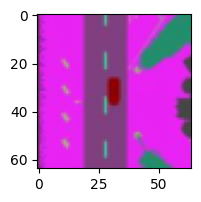

In [26]:
x = Variable(data).to(device)
plt.figure(figsize=(2,2))
plt.imshow(tv.utils.make_grid(x.detach().cpu(), nrow=16, normalize=True).permute(1, 2, 0))
plt.show()

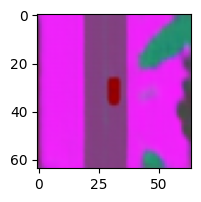

In [30]:
z = enc(x)
rec = dec(z)
y = rec.detach().cpu()
plt.figure(figsize=(2,2))
plt.imshow(tv.utils.make_grid(y,  nrow=16, normalize=True).permute(1, 2, 0))
plt.show()

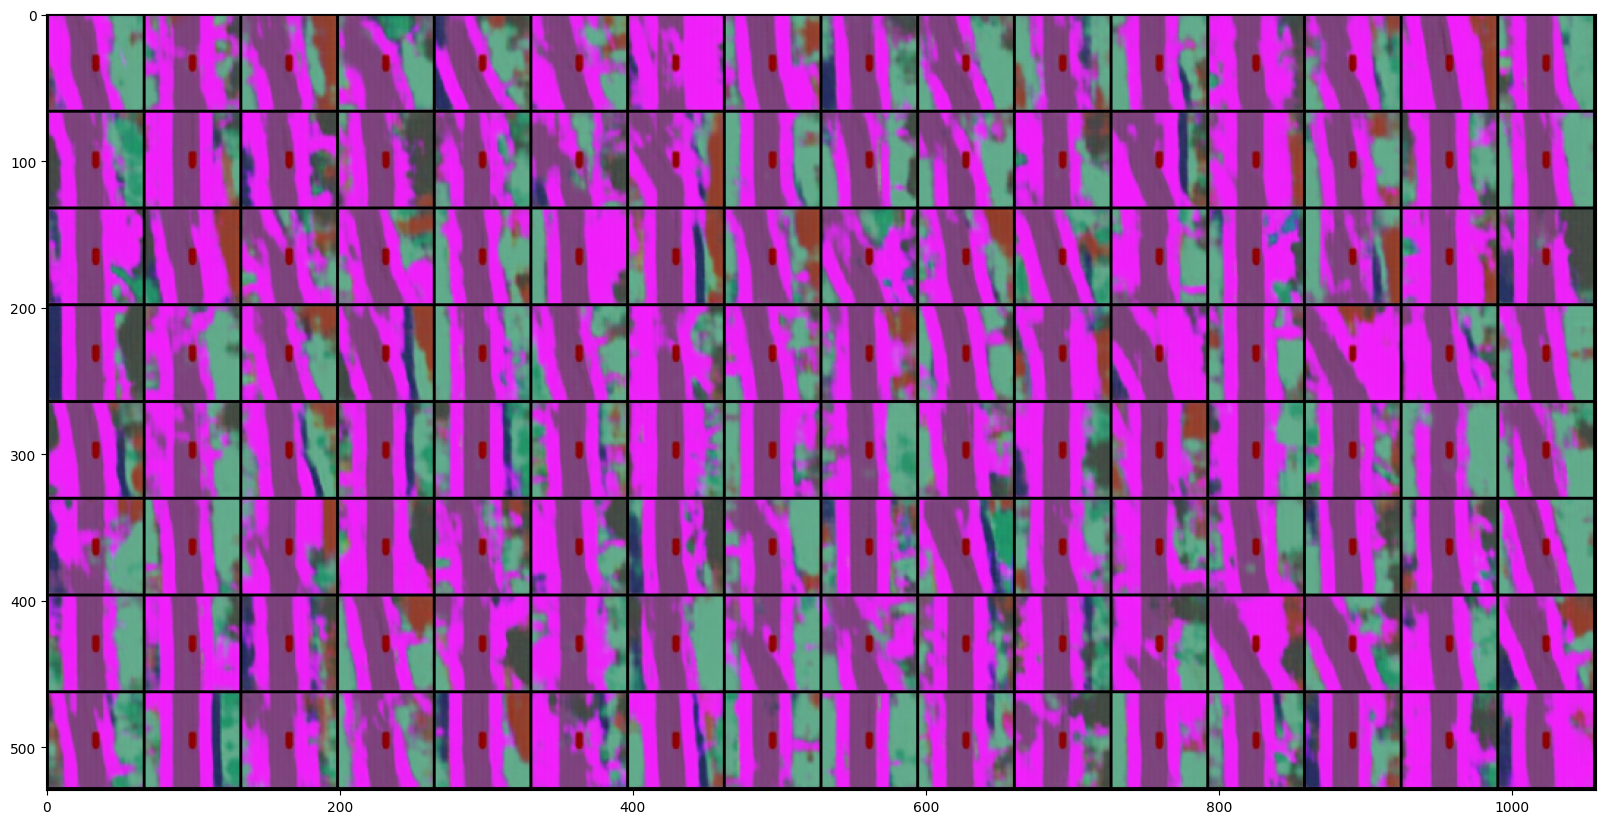

In [22]:
zp = Variable(torch.randn(batch_size, nz).to(device))
rec1 = dec(zp)
y1 = rec1.detach().cpu()
plt.figure(figsize=(20,20))
plt.imshow(tv.utils.make_grid(y1,  nrow=16, normalize=True).permute(1, 2, 0))
plt.show()

In [13]:
enc.load_state_dict(torch.load("enc.pth"))
dec.load_state_dict(torch.load("dec.pth"))
dis.load_state_dict(torch.load("dis.pth"))

<All keys matched successfully>

In [ ]:
x.size()

In [ ]:
z.size()

In [16]:
next(enumerate(dataloader))

(0,
 [tensor([[[[ 0.8510,  0.7804,  0.8353,  ...,  0.9137,  0.8510,  0.9137],
            [ 0.8431,  0.8745,  0.8431,  ...,  0.8510,  0.7804,  0.7412],
            [ 0.6235,  0.8118,  0.8275,  ...,  0.8980,  0.9059,  0.8039],
            ...,
            [-0.2157, -0.2157, -0.2157,  ...,  0.7020,  0.6863,  0.0588],
            [-0.2157, -0.2157, -0.2157,  ...,  0.6549,  0.7569,  0.2549],
            [-0.2157, -0.2157, -0.2157,  ...,  0.6157,  0.7725,  0.3333]],
  
           [[-0.7412, -0.7020, -0.7176,  ..., -0.7647, -0.7255, -0.7961],
            [-0.7255, -0.7412, -0.7176,  ..., -0.7176, -0.6863, -0.6941],
            [-0.5529, -0.7020, -0.7412,  ..., -0.7490, -0.7647, -0.7176],
            ...,
            [ 0.3333,  0.3333,  0.3333,  ..., -0.6392, -0.6784, -0.5843],
            [ 0.3333,  0.3333,  0.3333,  ..., -0.5765, -0.6706, -0.5843],
            [ 0.3333,  0.3333,  0.3333,  ..., -0.5529, -0.6784, -0.6314]],
  
           [[ 0.9137,  0.9216,  0.9137,  ...,  0.8902,  0.8588,  0